# SISTEMA DE INFERENCIA BORROSA TAKAGI – SUGENO

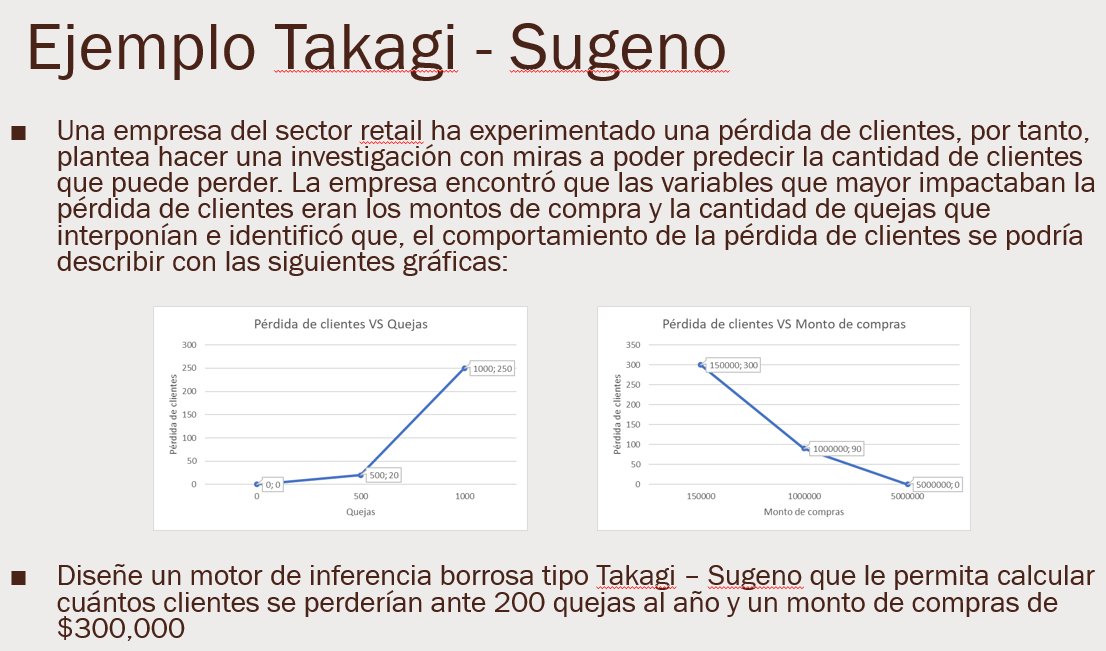

## Importar librerias

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import warnings
from itertools import product
from scipy.stats import linregress

warnings.filterwarnings("ignore")

## 1. Visualizar los conjuntos borrosos

Unicamente para visualizacion y ajuste para probar y crear buenos antecedentes

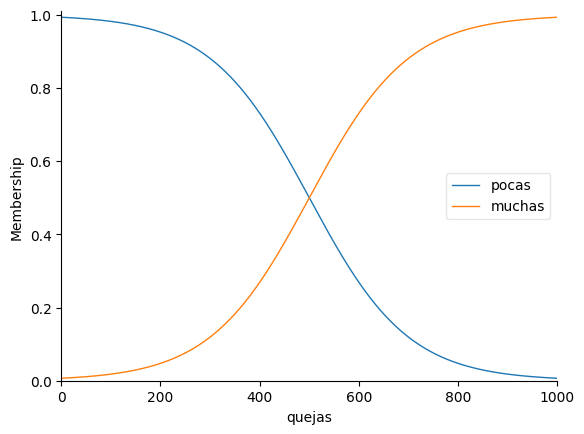

In [2]:
# Cantidad de quejas
#   Universos de discurso de fuzzificacion
quejas_x = np.array([0, 500, 1000])
quejas_y = np.array([0, 20, 250])

quejas = np.arange(quejas_x[0], quejas_x[2]+1, 1)
quejas_width = 0.01

quejas_ant = ctrl.Antecedent(quejas, 'quejas')
quejas_ant['pocas'] = fuzz.sigmf(quejas_ant.universe, quejas_x[1], -quejas_width)
quejas_ant['muchas'] = fuzz.sigmf(quejas_ant.universe, quejas_x[1], quejas_width)
quejas_ant.view()

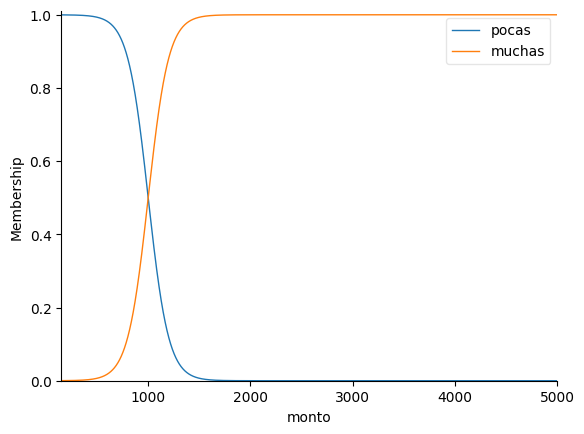

In [3]:
# Monto de compras
## Universos de dircurso y fuzzificacion
monto_x = np.array([150, 1000, 5000])
monto_y = np.array([300, 90, 0])

monto = np.arange(monto_x[0], monto_x[2]+1, 1)
monto_width = 0.01

monto_ant = ctrl.Antecedent(monto, 'monto')
monto_ant['pocas'] = fuzz.sigmf(monto_ant.universe, monto_x[1], -monto_width)
monto_ant['muchas'] = fuzz.sigmf(monto_ant.universe, monto_x[1], monto_width)
monto_ant.view()

## 2. Declarar los antecedentes

In [3]:
data_antecedentes = [
  {'x': [0, 25, 80, 95], 'y': [5, 18, 25, 30], 'universe': np.arange(0, 101, 1)},
  {'x': [7, 12, 19, 22], 'y': [5, 18, 25, 30], 'universe': np.arange(0, 26, 1)},
]

In [5]:
opciones_antecedentes = [
  # Quejas
  [
    fuzz.sigmf(quejas, quejas_x[1], -quejas_width),
    fuzz.sigmf(quejas, quejas_x[1], quejas_width)
  ],
  # Monto
  [
    fuzz.sigmf(monto, monto_x[1], -monto_width),
    fuzz.sigmf(monto, monto_x[1], monto_width)
  ]
]

## 3. Obtener las funciones afines del consecuente

In [5]:
def calcular_m_b_segmento(antecedentes):
  resultados = []

  for antecedente in antecedentes:
    x_vals = antecedente['x']
    y_vals = antecedente['y']

    segmentos = []
    for i in range(len(x_vals) - 1):
        l = linregress([x_vals[i], x_vals[i+1]], [y_vals[i], y_vals[i+1]])
        segmentos.append({'m': l.slope, 'b': l.intercept})

    resultados.append(segmentos)

  return resultados

data_segmentos = calcular_m_b_segmento(data_antecedentes)
for i, segmentos in enumerate(data_segmentos):
  print(f"Antecedente {i+1}:")
  for j, segmento in enumerate(segmentos):
      print(f"  Segmento {j+1}: m = {segmento['m']:.2f}, b = {segmento['b']:.2f}")

Antecedente 1:
  Segmento 1: m = 0.52, b = 5.00
  Segmento 2: m = 0.13, b = 14.82
  Segmento 3: m = 0.33, b = -1.67
Antecedente 2:
  Segmento 1: m = 2.60, b = -13.20
  Segmento 2: m = 1.00, b = 6.00
  Segmento 3: m = 1.67, b = -6.67


## 4. Crear la base de conocimiento

In [7]:
def calcular_combinacion_segmentos_reglas(
    combinaciones, deffuzificar, segmentos_antecedentes, antecedentes, opciones_antecedentes
  ):
  combinacion_segmentos = {}
  reglas = {}

  for combinacion in combinaciones:
    resultado = 0
    memberships = []
    for i, idx in enumerate(combinacion):
      # Combinacion de segmentos
      segmento = segmentos_antecedentes[i][idx]
      resultado += segmento['m'] * deffuzificar[i] + segmento['b']

      # Combinacion de reglas
      antecedente = antecedentes[i]
      opcion = opciones_antecedentes[i][idx]
      membership = fuzz.interp_membership(antecedente['universe'], opcion, deffuzificar[i])
      memberships.append(membership)

    combinacion_segmentos[combinacion] = resultado
    reglas[combinacion] = min(memberships)

  return combinacion_segmentos, reglas

## 5. Construir el defuzzificador

In [8]:
def deffuzificador (deffuzificar, antecedentes, opciones_antecedentes):
  # Sacar a cada segmento su m y b
  data_segmentos = calcular_m_b_segmento(antecedentes)
  # for i, segmentos in enumerate(data_segmentos):
  #   print(f"Antecedente {i+1}:")
  #   for j, segmento in enumerate(segmentos):
  #       print(f"  Segmento {j+1}: m = {segmento['m']:.2f}, b = {segmento['b']:.2f}")

  # Calcular todas las combinaciones posibles ([0,0,0,0], [0,0,0,1], ...)
  combinaciones = list(product(*[range(len(segmentos)) for segmentos in data_segmentos]))

  # Calcular el resultado de cada combinacion de segmentos y la regla
  combinaciones_segmentos, reglas = calcular_combinacion_segmentos_reglas(combinaciones, deffuzificar, data_segmentos, antecedentes, opciones_antecedentes)
  # Imprimir resultados de las combinaciones de las segmentos
  for combinacion, resultado in combinaciones_segmentos.items():
    print(f"Combinación {combinacion}: {resultado:.4f}, Regla: {reglas[combinacion]:.4f}")

  # Calcular el resultado final
  num = 0
  den = 0

  for combinacion in combinaciones_segmentos:
    r = combinaciones_segmentos[combinacion]
    mu = reglas[combinacion]
    num += mu * r
    den += mu

  print(num, den)

  return num / den if den != 0 else 0

## 6. Usar el deffuzificador

In [11]:
deffuzificar = [200, 300]
resultado = deffuzificador(deffuzificar, data_antecedentes, opciones_antecedentes)
print(f"Resultado: {resultado:.4f}")

Combinación (0, 0): 270.9412, Regla: 0.9526
Combinación (0, 1): 113.7500, Regla: 0.0009
Combinación (1, 0): 144.9412, Regla: 0.0474
Combinación (1, 1): -12.2500, Regla: 0.0009
265.0579881464465 1.0018221023888014
Resultado: 264.5759


# Pruebas

In [10]:
def deffuzificador_tests(deffuzificar, antecedentes, opciones_antecedentes):
  # print('antecedentes:', antecedentes)
  # Sacar a cada segmento su m y b
  data_segmentos = calcular_m_b_segmento(antecedentes)
  for i, segmentos in enumerate(data_segmentos):
      print(f"Antecedente {i+1}:")
      for j, segmento in enumerate(segmentos):
          print(f"  Segmento {j+1}: m = {segmento['m']:.2f}, b = {segmento['b']:.2f}")

  # Calcular todas las combinaciones posibles ([0,0,0,0], [0,0,0,1], ...)
  combinaciones = list(product(*[range(len(segmentos)) for segmentos in data_segmentos]))
  # print('combinaciones:', combinaciones)

  def regla_test (deffuzificar, combinacion):
    mu1 = min(
      fuzz.interp_membership(quejas, opciones_antecedentes[0], deffuzificar[0]),
      fuzz.interp_membership(monto, opciones_antecedentes[1], deffuzificar[1])
    )
    return mu1

  combinacion_test = [0, 1, 0, 1]
  print("Regla Test:", combinacion_test)
  print(regla_test(deffuzificar, combinacion_test))

  # Calcular el resultado de cada combinacion de segmentos y la regla
  combinaciones_segmentos, reglas = calcular_combinacion_segmentos_reglas(combinaciones, deffuzificar, data_segmentos, antecedentes, opciones_antecedentes)
  for combinacion, resultado in combinaciones_segmentos.items():
    print(f"Combinación {combinacion}: {resultado:.4f}, regla: {reglas[combinacion]:.4f}")

  # Calcular el resultado final
  num = 0
  den = 0

  for combinacion in combinaciones_segmentos:
    r = combinaciones_segmentos[combinacion]
    mu = reglas[combinacion]
    num += mu * r
    den += mu

  print('num:', num)
  print('den:', den)

  return num / den if den != 0 else 0

deffuzificar = [200, 300]
resultado = deffuzificador(deffuzificar, data_antecedentes, opciones_antecedentes)
print(f"Resultado: {resultado:.4f}")

Combinación (0, 0): 270.9412, Regla: 0.9526
Combinación (0, 1): 113.7500, Regla: 0.0009
Combinación (1, 0): 144.9412, Regla: 0.0474
Combinación (1, 1): -12.2500, Regla: 0.0009
265.0579881464465 1.0018221023888014
Resultado: 264.5759
